In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#filename = './Output_2018_2021_Braidwood_periodic/synthetic.csv'
filename = "./Output_Braidwood_2012_2021_DA_periodic/synthetic.csv"
synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
synthetic_df

,hour,Year,synthetic price
0,1,2012,19.025470
1,1,2013,24.884340
2,1,2014,31.827815
3,1,2015,18.190709
4,1,2016,21.740072
...,...,...,...
332847,8760,2017,57.887478
332848,8760,2018,24.870250
332849,8760,2019,15.613875
332850,8760,2020,19.634070


In [4]:
data_dir = '../data/electricity_markets/PJM_braidwood/'
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  year = int(f.split('_')[0])
  file = data_dir+f
  df = pd.read_csv(file)
  df['Year'] = [year for i in range(len(df))]
  li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df

,hour,historical price,Year
0,1.0,25.02,2017
1,2.0,24.32,2017
2,3.0,24.17,2017
3,4.0,23.95,2017
4,5.0,24.09,2017
...,...,...,...
87595,8756.0,28.52,2021
87596,8757.0,26.37,2021
87597,8758.0,24.87,2021
87598,8759.0,24.80,2021


Merge historical and synthetic data

In [5]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,hour,historical price,Year,synthetic price
0,1.0,25.02,2017,16.771373
1,2.0,24.32,2017,18.720646
2,3.0,24.17,2017,23.725417
3,4.0,23.95,2017,24.620125
4,5.0,24.09,2017,26.133125
...,...,...,...,...
87595,8756.0,28.52,2021,24.492201
87596,8757.0,26.37,2021,25.932525
87597,8758.0,24.87,2021,27.966584
87598,8759.0,24.80,2021,21.843669


In [6]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
stats_df.to_excel('ARMA_stats.xlsx',sheet_name=tag)
stats_df

,historical price,synthetic price
count,87600.000000,87600.000000
mean,32.977090,32.979372
std,23.072473,23.117209
min,2.270000,2.270000
25%,22.720000,22.653519
50%,28.840000,28.817658
75%,37.000000,37.036060
max,933.680000,933.680000
kurtosis,243.297540,241.622561
skewness,10.856814,10.799669


In [7]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,25.020000
1,historical,24.320000
2,historical,24.170000
3,historical,23.950000
4,historical,24.090000
...,...,...
332847,synthetic,57.887478
332848,synthetic,24.870250
332849,synthetic,15.613875
332850,synthetic,19.634070


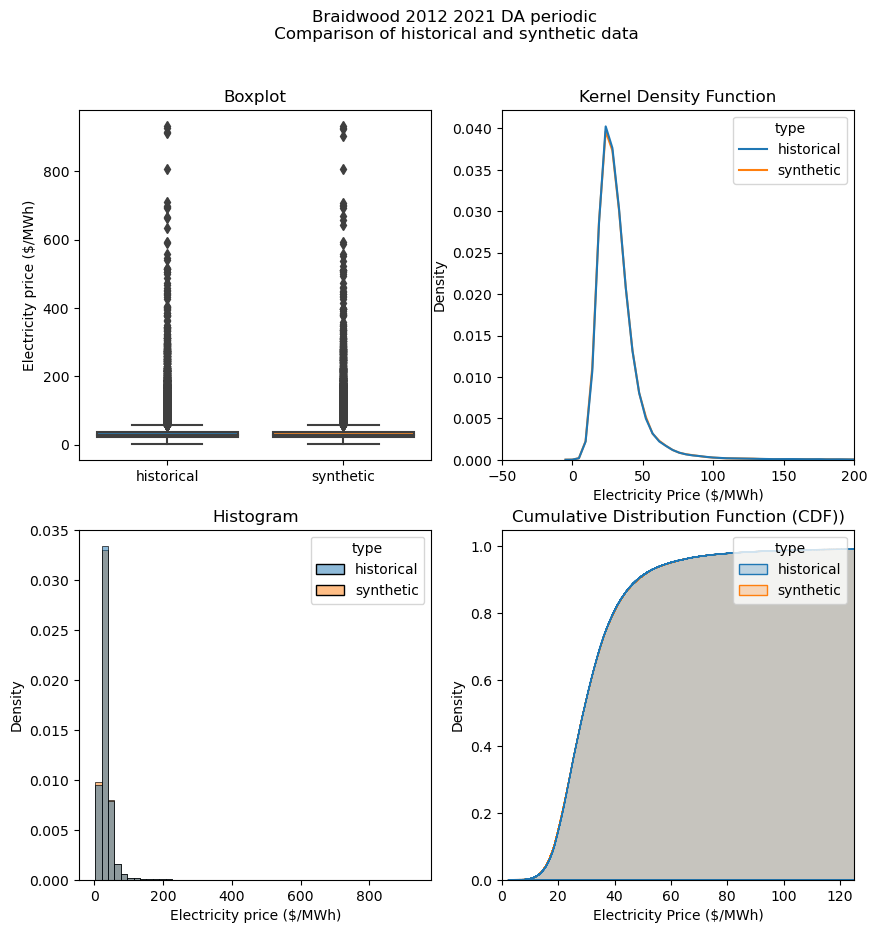

In [8]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(2,2,figsize =(10,10))

title = ' '.join(tag.split('_'))+'\n Comparison of historical and synthetic data'
fig.suptitle(title)

sns.boxplot(ax = axes[0,0],data=prices_df, x='type', y='price')
axes[0,0].set_title('Boxplot')
axes[0,0].set_ylabel('Electricity price ($/MWh)')
axes[0,0].set_xlabel('')

sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=50, stat='density', common_norm=False)
axes[1,0].set_title('Histogram')
axes[1,0].set_xlabel('Electricity price ($/MWh)')

sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type',common_norm=False)
axes[0,1].set_title('Kernel Density Function')
axes[0,1].set_xlabel('Electricity Price ($/MWh)')
axes[0,1].set_xlim(-50,200)

sns.histplot(ax = axes[1,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[1,1].set_title('Cumulative Distribution Function (CDF))')
axes[1,1].set_xlabel('Electricity Price ($/MWh)')
axes[1,1].set_xlim(0,125)

fig.savefig(tag+'_comparison_plots.png')

